In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from cnn_bilstm_am import Attention, prepare_data
import warnings
warnings.filterwarnings("ignore")

In [32]:
# inverse transform closing price
def inverse_scale(y, scaler):
    return y * scaler.scale_[3] + scaler.mean_[3]

# model builders
def create_mlp_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=1, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=1, padding='same'),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=1, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=1, padding='same'),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_cnn_bilstm_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=1, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=1, padding='same'),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_bilstm_am_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Attention()(x)
    output = Dense(1)(x)
    model = Model(inputs, outputs=output)
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def create_cnn_bilstm_am_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=1, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=1, padding='same')(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Attention()(x)
    output = Dense(1)(x)
    model = Model(inputs, outputs=output)
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

# evaluation
def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test).flatten()
    y_pred_unscaled = inverse_scale(y_pred, scaler)
    y_test_unscaled = inverse_scale(y_test, scaler)
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    return y_pred_unscaled, y_test_unscaled, mae, rmse, r2

# plotting
def plot_all_predictions(y_actual, predictions):
    days = range(len(y_actual))
    plt.figure(figsize=(15, 10))
    plt.plot(days, y_actual, 'k-', label='Actual', linewidth=2)
    for name, y_pred in predictions.items():
        plt.plot(days, y_pred, '--', label=name, alpha=0.7)
    plt.title('INFY Stock Price Predictions Comparison')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

# plotting
def plot_individual_predictions(y_actual, predictions):
    days = range(len(y_actual))

    for name, y_pred in predictions.items():
        plt.figure(figsize=(12, 6))
        plt.plot(days, y_actual, label='Actual Closing Price')
        plt.plot(days, y_pred, label=f'Predicted Closing Price')

        # Calculate metrics for this model to display in the title
        mae = mean_absolute_error(y_actual, y_pred)
        rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        r2 = r2_score(y_actual, y_pred)

        plt.title(f'INFY Stock Closing Price Prediction ({name})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        plt.savefig(f'{name}.png')
        plt.show()


In [33]:
# run all models
def compare_all_models(data_path, time_steps=5, epochs=100, batch_size=64):
    df = pd.read_csv(data_path, index_col=0)
    df = df[['opening_price', 'highest_price', 'lowest_price', 'closing_price', 'volume', 'turnover', 'ups_and_downs', 'change']]

    # standardize
    scaler = StandardScaler()
    features = scaler.fit_transform(df.values)

    # sequence generation
    X, y = prepare_data(features, time_steps)
    X_train, X_test = X[:-1000], X[-1000:]
    y_train, y_test = y[:-1000], y[-1000:]

    model_creators = [
        ('MLP', create_mlp_model),
        ('CNN', create_cnn_model),
        ('RNN', create_rnn_model),
        ('LSTM', create_lstm_model),
        ('BiLSTM', create_bilstm_model),
        ('CNN-LSTM', create_cnn_lstm_model),
        ('CNN-BiLSTM', create_cnn_bilstm_model),
        ('BiLSTM-AM', create_bilstm_am_model),
        ('CNN-BiLSTM-AM', create_cnn_bilstm_am_model),
    ]

    results = []
    predictions = {}

    for name, model_func in model_creators:
        print(f"\nTraining model: {name}")
        model = model_func(input_shape=X_train.shape[1:])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

        y_pred, y_actual, mae, rmse, r2 = evaluate_model(model, X_test, y_test, scaler)

        results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
        predictions[name] = y_pred

    results_df = pd.DataFrame(results)
    print("\nModel Performance Comparison:")
    print(results_df.to_string(index=False))

    # plot
    # plot_all_predictions(y_actual, predictions)
    plot_individual_predictions(y_actual, predictions)

    return results_df, predictions, y_actual


Training model: MLP
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training model: CNN
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training model: RNN
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Training model: LSTM
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Training model: BiLSTM
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Training model: CNN-LSTM
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Training model: CNN-BiLSTM
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Training model: BiLSTM-AM
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Training model: CNN-BiLSTM-AM
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Model Performance Comparison:
        Model       MAE      RMSE       R²
          MLP 41.013222 73.304850 0.845110
          CNN 30.623542 44.814883 0.942110
          RNN 29.369858 53.561875 0.917307
         LSTM 29.911106 41.759946 0.949734
       BiLSTM 25.407007 38.827491 0.956545
     CNN-LSTM 23.174152 32.071893 0.970351
   CNN-BiLSTM 23.351304 34.218578 0.966249
    BiLSTM-AM 20.695177 28.995543 0.975766
CNN-Bi

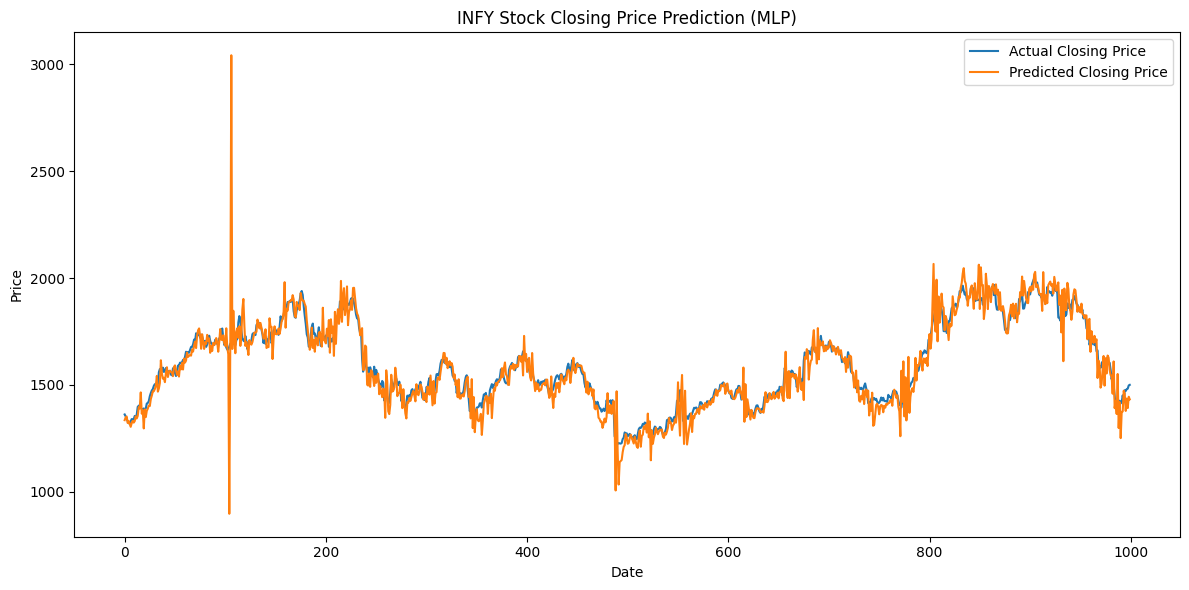

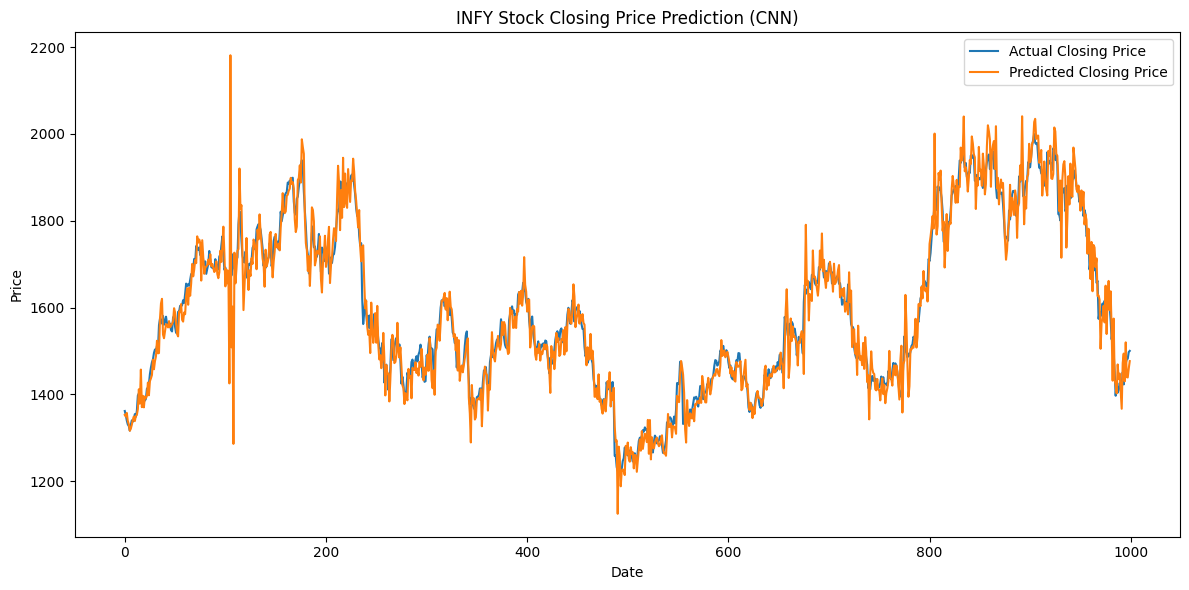

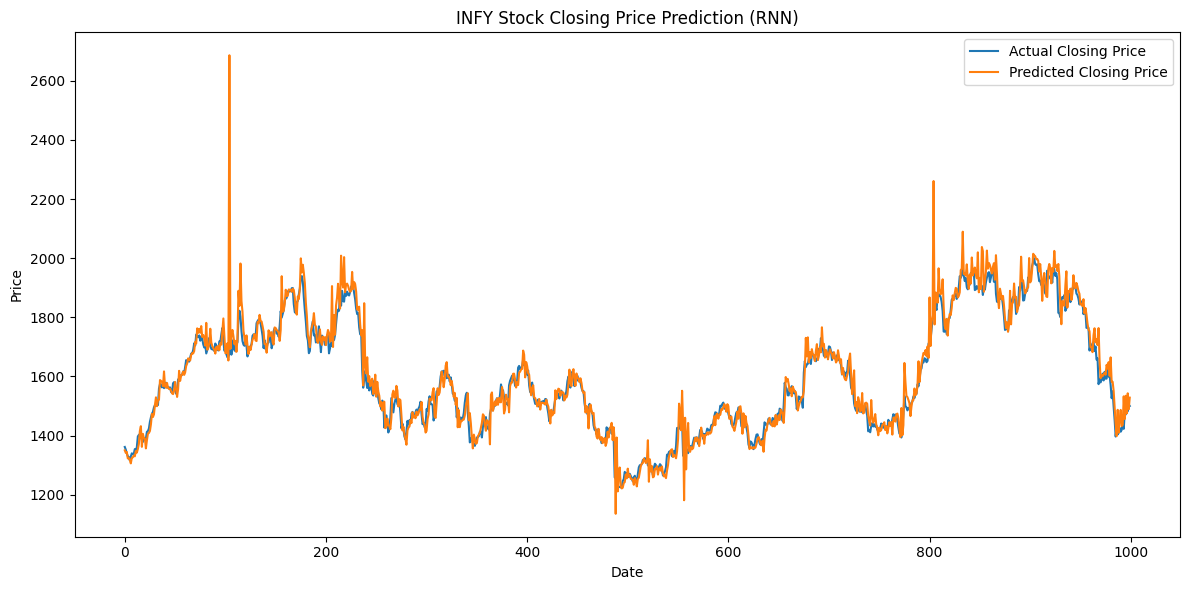

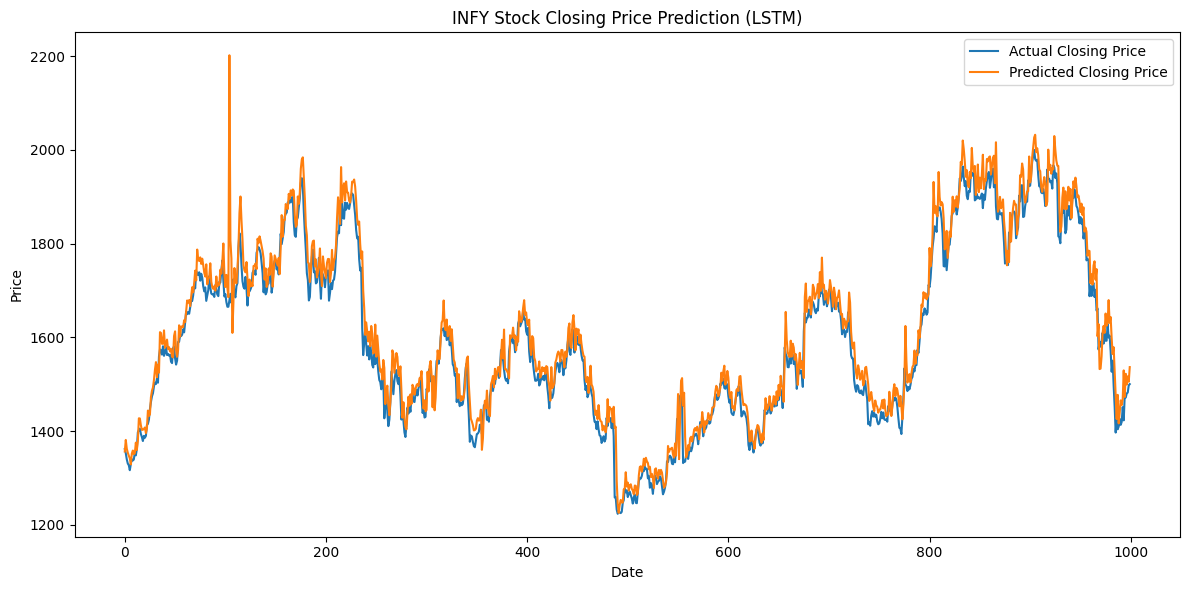

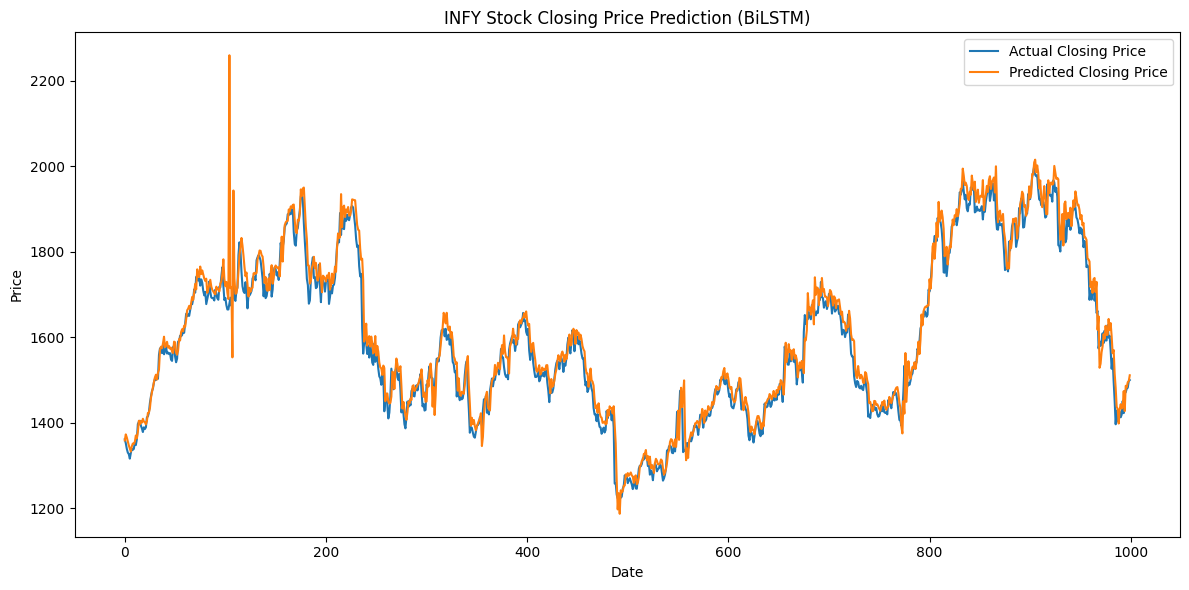

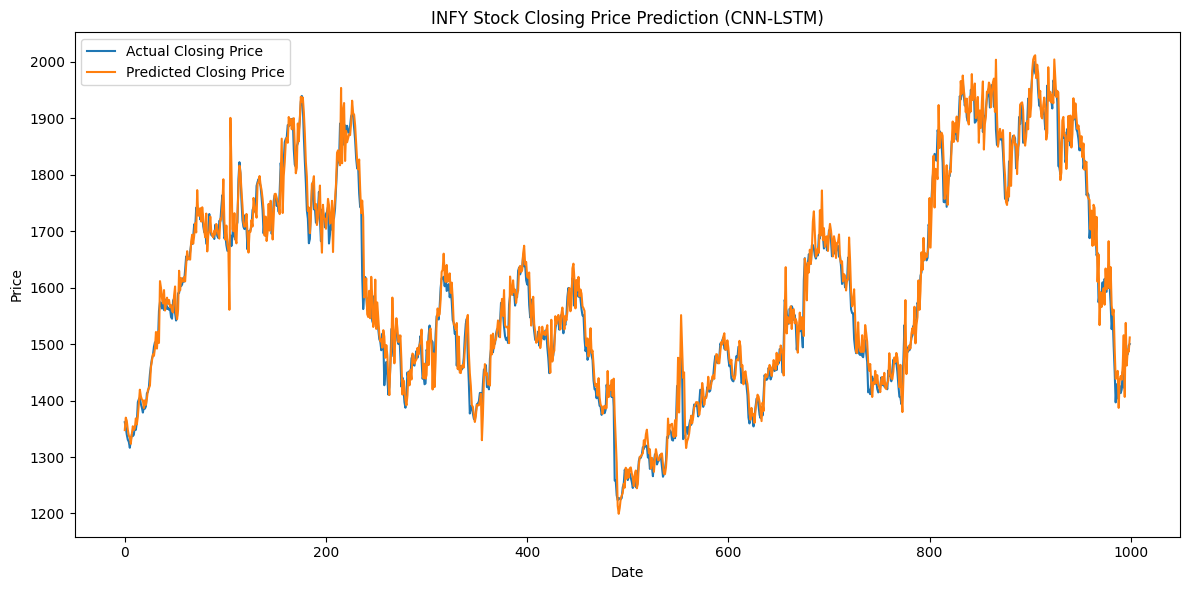

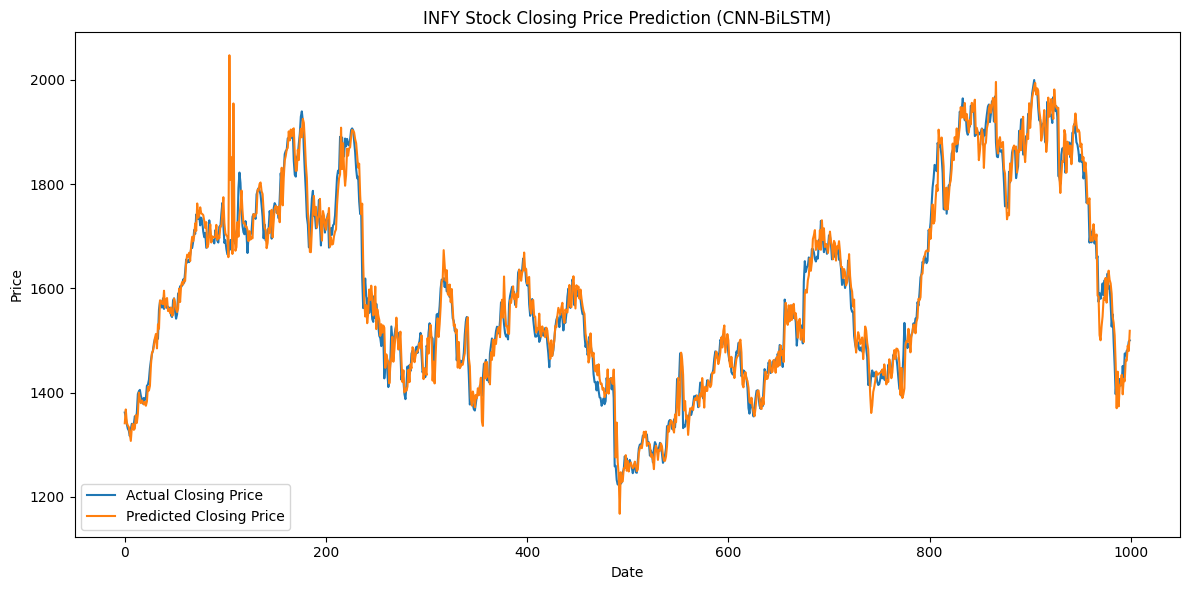

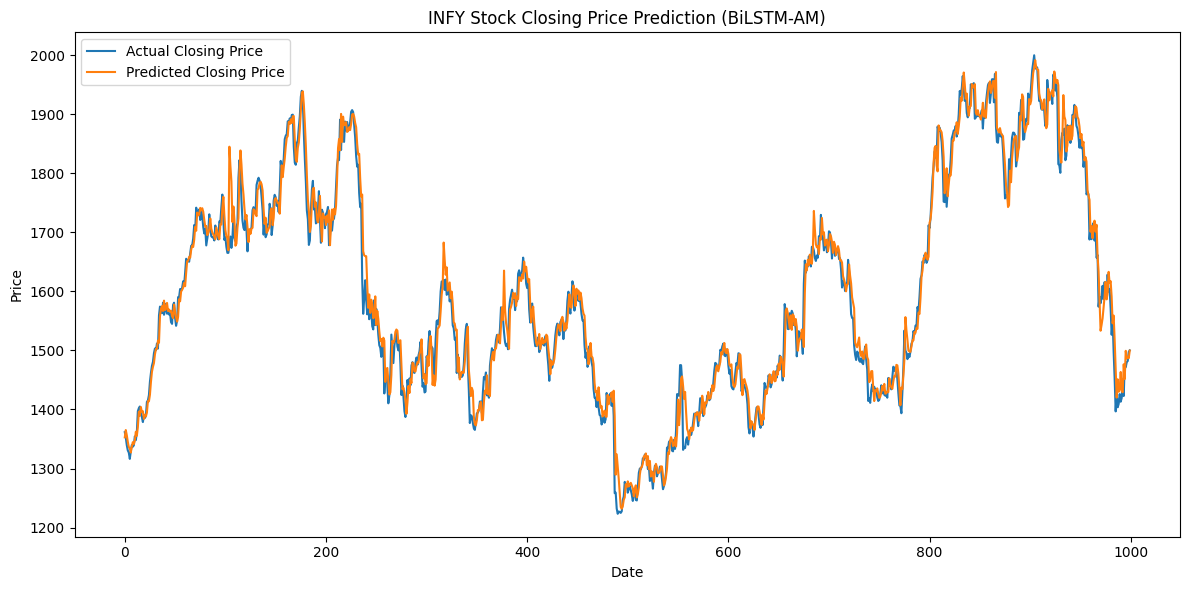

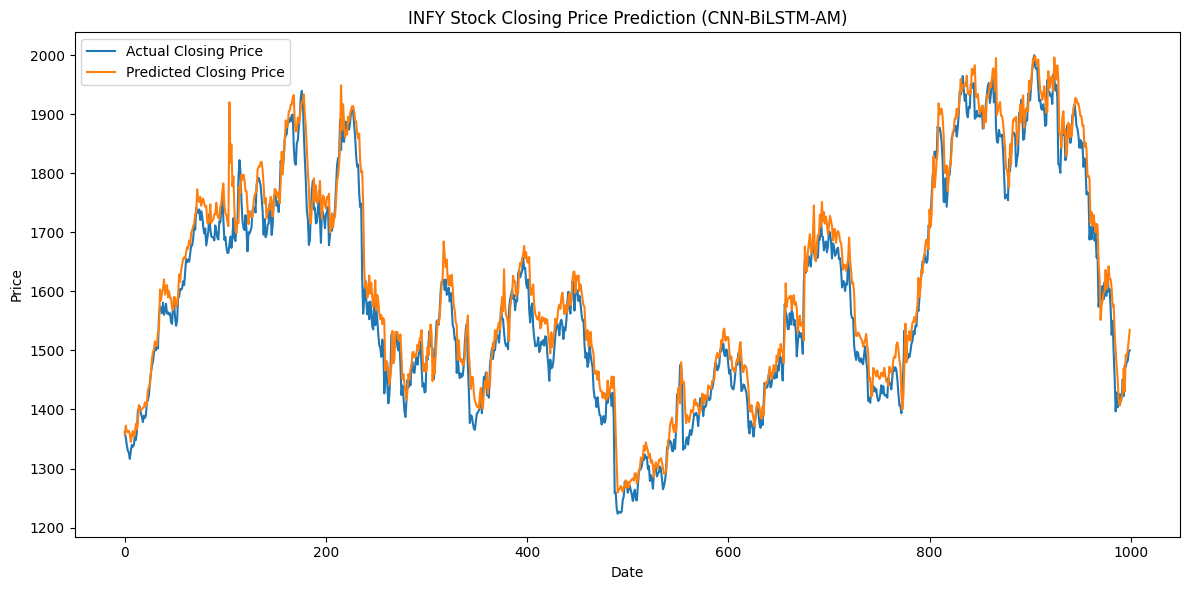

In [34]:
results_df, preds, actual = compare_all_models("INFY.csv")